# Usefull libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import hilbert
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.model_selection import train_test_split

2024-04-17 22:13:58.057801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 22:13:58.057904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 22:13:58.221140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading data

In [2]:
data_path = 'REM_NREM.csv'
data = pd.read_csv(data_path)

# Display the first few rows
data.head()


,Sleep_Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,...,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
0,NREM,0.00034,10.11512,17.85756,17.48293,10.24000,0.00047,17.73268,25.35024,27.47317,...,0.00112,0.74927,6.36878,2.87220,0.62439,0.000076,32.71805,43.83220,49.95122,49.95122
1,NREM,0.00035,10.73951,17.60780,17.10829,9.11610,0.00048,16.85854,25.22537,26.97366,...,0.00070,0.99902,6.86829,3.62146,0.74927,0.000072,32.09366,44.33171,49.95122,49.95122
2,NREM,0.00035,9.36585,17.60780,16.98341,9.24098,0.00042,17.35805,26.09951,28.47220,...,0.00077,1.49854,6.49366,4.12098,0.74927,0.000069,33.09268,43.95707,49.95122,49.95122
3,NREM,0.00050,10.36488,16.60878,15.85951,7.99220,0.00053,15.48488,24.10146,25.72488,...,0.00130,1.87317,6.11902,3.74634,0.37463,0.000070,31.59415,42.83317,49.95122,49.95122
4,NREM,0.00072,9.36585,15.98439,15.48488,7.99220,0.00067,15.11024,22.22829,23.22732,...,0.00123,1.49854,6.61854,3.74634,0.74927,0.000060,29.47122,45.08098,49.95122,49.95122


# Checking for missing values in the data

In [3]:
missing_values = data.isnull().sum()

missing_values[missing_values > 0]


Series([], dtype: int64)

# Data Preprocessing

## Remove artifacts and noise using Z_score (considering values with Z > 3 or Z < -3 as outliers)

In [4]:
numeric_data = data.select_dtypes(include=[np.number])

z_scores_numeric = numeric_data.apply(zscore)

outliers_z_numeric = (z_scores_numeric.abs() > 3).sum()

outliers_z_numeric[outliers_z_numeric > 0]


MeanP_Alpha_F4             145
MedianF_Alpha_F4          1404
MeanF_Alpha_F4            1875
Spectral Edge_Alpha_F4    1953
PeakF_Alpha_F4            1163
                          ... 
MeanP_Gamma_O2             489
MedianF_Gamma_O2          1232
MeanF_Gamma_O2            1232
Spectral Edge_Gamma_O2    1233
PeakF_Gamma_O2            1232
Length: 75, dtype: int64

In [5]:
rows_with_outliers = (z_scores_numeric.abs() > 3).any(axis=1)

# Count of rows before removal
rows_before = data.shape[0]

# Remove rows with outliers
cleaned_data = data[~rows_with_outliers]

# Count of rows after removal
rows_after = cleaned_data.shape[0]

rows_before, rows_after


(89096, 82163)

# Time-Frequency Analysis

## Spectrogram analysis for MeanP_Alpha_F4

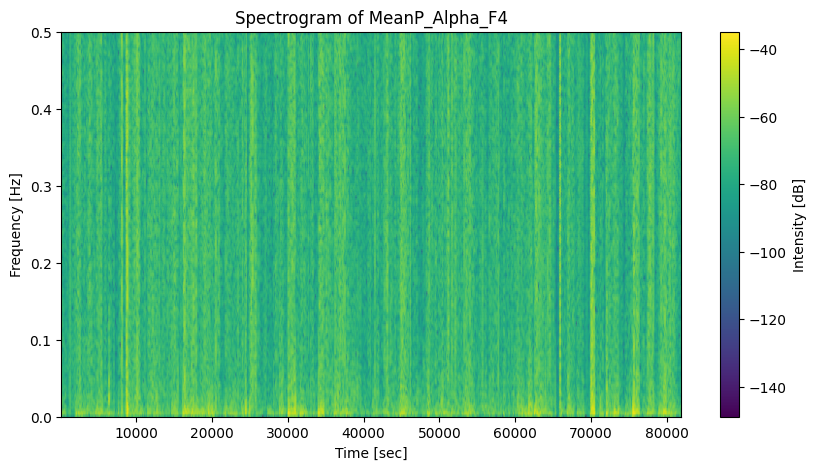

In [6]:
signal_data = cleaned_data['MeanP_Alpha_F4']

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(signal_data, fs=1, nperseg=256, noverlap=128)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of MeanP_Alpha_F4')
plt.colorbar(label='Intensity [dB]')
plt.show()


## Insights
### Alpha Activity
This feature likely captures fluctuations in Alpha activity, which is often related to different states of wakefulness or sleep. Variations in the spectrogram could correlate with transitions between different sleep stages or changes in brain activity levels.

## Temporal Analysis
Analyzing changes over time could help identify specific patterns or anomalies associated with different sleep stages or disturbances.



## Moving Averages

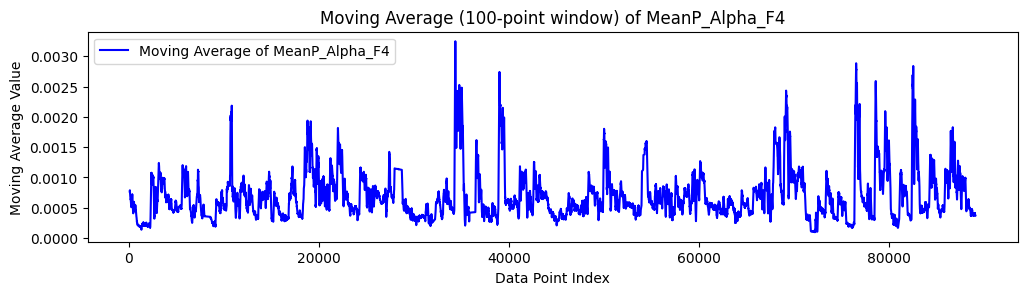

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot( cleaned_data['MeanP_Alpha_F4'].rolling(window=100).mean(), label='Moving Average of MeanP_Alpha_F4', color='blue')
plt.title('Moving Average (100-point window) of MeanP_Alpha_F4')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average Value')
plt.legend()


## Insights
### Gradual Trends
The moving average for the Alpha band shows gradual increases and decreases over the dataset. Alpha activity is typically associated with relaxed, wakeful states and is prominently visible during quiet, waking states and light sleep.

### Fluctuations
The smoother fluctuations indicate transitions between different sleep stages or states of alertness. A decrease in Alpha power is often observed as individuals move from wakefulness into deeper sleep stages.

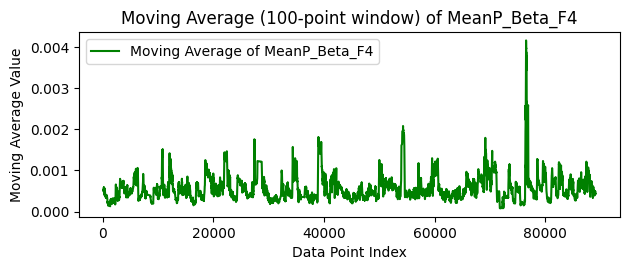

In [8]:
plt.subplot(2, 1, 2)
plt.plot(cleaned_data['MeanP_Beta_F4'].rolling(window=100).mean(), label='Moving Average of MeanP_Beta_F4', color='green')
plt.title('Moving Average (100-point window) of MeanP_Beta_F4')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average Value')
plt.legend()

plt.tight_layout()
plt.show()

## Insights
### Sharper Variations
The Beta band plot shows sharper variations compared to Alpha, reflecting its nature as a band associated with active thinking and alertness. Beta activity is high during awake, attentive states, such as REM sleep, where dreaming typically occurs.
### Consistent Peaks
Peaks in Beta power may indicate moments of heightened cognitive activity, possibly related to dreams or brief wakeful intervals during sleep..


# Connectivity Analysis

## Coherence between MeanP_Alpha_F4 and MeanP_Alpha_F2

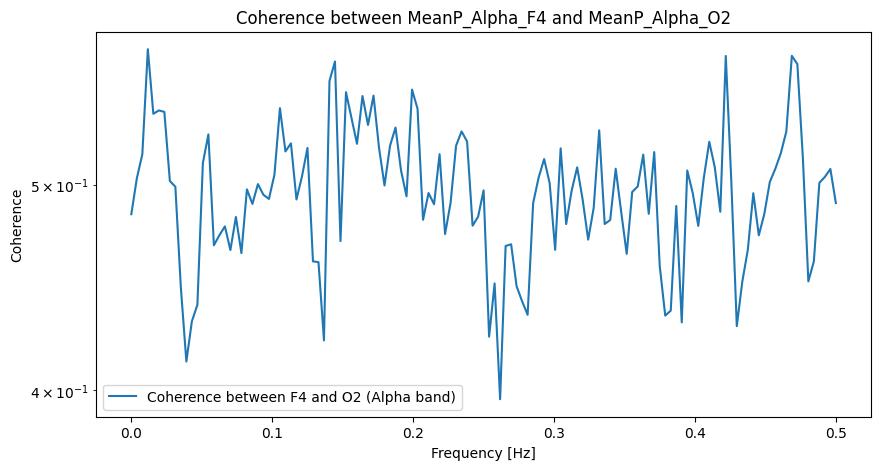

In [9]:
from scipy.signal import coherence

alpha_f4 = cleaned_data['MeanP_Alpha_F4']
alpha_o2 = cleaned_data['MeanP_Alpha_O2']

frequencies, coh = coherence(alpha_f4, alpha_o2, fs=1, nperseg=256)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, coh, label='Coherence between F4 and O2 (Alpha band)')
plt.title('Coherence between MeanP_Alpha_F4 and MeanP_Alpha_O2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.legend()
plt.show()


## Insights
### Frequency Dependence
The coherence varies across different frequencies, highlighting areas where the signals are more or less synchronized. This can inform us about the communication patterns between the frontal and occipital regions during different cognitive or sleep states.

### Significant Coherence
Peaks in the coherence plot suggest frequencies at which the two regions share more significant functional connectivity. These peaks are particularly interesting for further investigation into what those frequencies might mean in terms of brain function during sleep.

## Coherence between MeanP_Beta_F4 and MeanP_Beta_F2

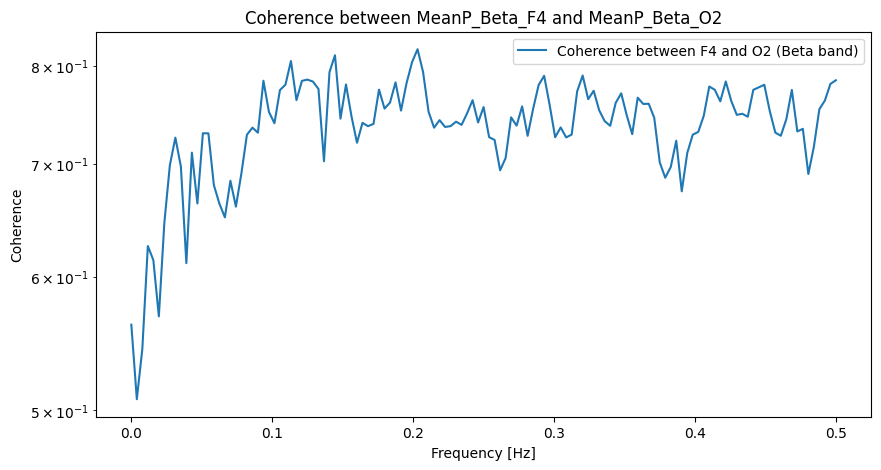

In [10]:
beta_f4 = cleaned_data['MeanP_Beta_F4']
beta_o2 = cleaned_data['MeanP_Beta_O2']

beta_frequencies, beta_coh = coherence(beta_f4, beta_o2, fs=1, nperseg=256)

plt.figure(figsize=(10, 5))
plt.semilogy(beta_frequencies, beta_coh, label='Coherence between F4 and O2 (Beta band)')
plt.title('Coherence between MeanP_Beta_F4 and MeanP_Beta_O2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.legend()
plt.show()


## Insights
## Frequency Distribution
The coherence varies across frequencies, indicating the degree of synchronization between these two regions at different Beta frequencies.

## Notable Coherence Peaks
Where we see peaks, these suggest stronger connectivity at certain frequencies. These areas might be particularly relevant during tasks that require visual processing or during REM sleep when the occipital region might be more active.

## Synchronization between beta_f4 and beta_o2 using hilbert

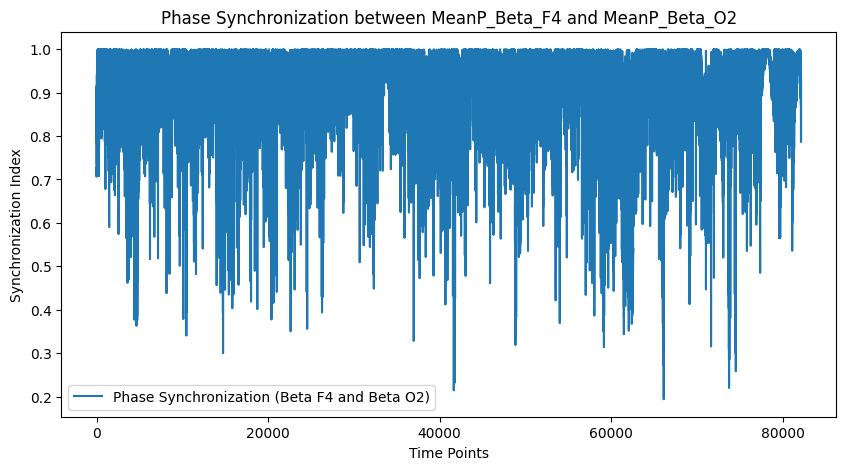

In [11]:
def phase_synchronization(signal1, signal2):
    analytic_signal1 = hilbert(signal1)
    analytic_signal2 = hilbert(signal2)
    
    phase1 = np.angle(analytic_signal1)
    phase2 = np.angle(analytic_signal2)
    
    # phase difference
    phase_diff = np.abs(phase1 - phase2)
    
    # Calculate the phase synchronization index
    sync_index = 1 - phase_diff / np.pi
    
    return sync_index

phase_sync = phase_synchronization(beta_f4, beta_o2)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(phase_sync, label='Phase Synchronization (Beta F4 and Beta O2)')
plt.title('Phase Synchronization between MeanP_Beta_F4 and MeanP_Beta_O2')
plt.xlabel('Time Points')
plt.ylabel('Synchronization Index')
plt.legend()
plt.show()


## Insights
### Variability in Synchronization
The plot shows varying levels of synchronization over time. Peaks in synchronization might indicate moments when the frontal and occipital regions are particularly in sync, potentially during specific cognitive tasks or sleep stages.
### Insights into Brain Communication
This metric provides insights into how these regions might be communicating or sharing information at specific times, without the influence of signal amplitude.


# Neural Network Modeling

## Prepare the data

In [12]:
X = cleaned_data.drop('Sleep_Stage', axis=1)
y = cleaned_data['Sleep_Stage'].apply(lambda x: 1 if x == 'REM' else 0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


## Normalize the data

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for LSTM input

In [14]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_train_scaled.shape,X_val_scaled.shape

((65730, 75, 1), (16433, 75, 1))

## Define and compile the LSTM model

In [15]:
model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    LSTM(32, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Use an Adam optimizer 
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [16]:
history=model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=16, batch_size=64)

Epoch 1/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7807 - loss: 0.5339 - val_accuracy: 0.8156 - val_loss: 0.4507
Epoch 2/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8144 - loss: 0.4569 - val_accuracy: 0.8177 - val_loss: 0.4445
Epoch 3/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8168 - loss: 0.4507 - val_accuracy: 0.8181 - val_loss: 0.4414
Epoch 4/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8161 - loss: 0.4496 - val_accuracy: 0.8187 - val_loss: 0.4392
Epoch 5/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8180 - loss: 0.4444 - val_accuracy: 0.8191 - val_loss: 0.4382
Epoch 6/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8202 - loss: 0.4405 - val_accuracy: 0.8176 - val_loss: 0.4404
Epoch 7/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8193 - loss: 0.4401 - val_accuracy: 0.8192 - val_loss: 0.4341
Epoch 8/16
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8213 - loss: 0.4340 -

# Interpretation and Visualization

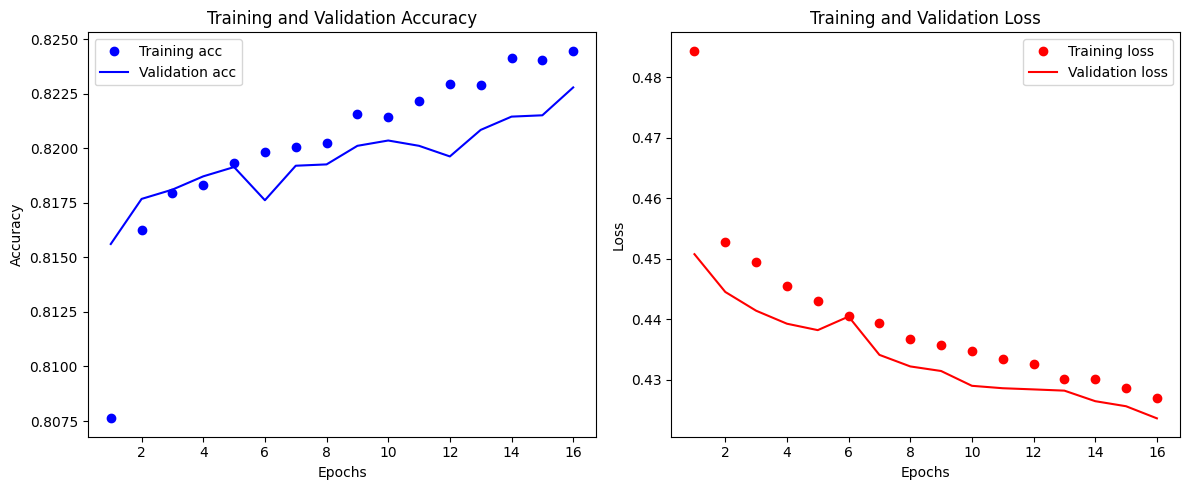

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Convergence Behavior
Both training and validation losses decrease consistently as the epochs progress, suggesting that the model is learning effectively and improving its ability to generalize as more training steps are completed.
The final training loss and the final validation loss are relatively close, indicating good generalization without significant overfitting.

## Accuracy Improvement:
The improvement of training accuracy from 78.29% and to 82.40% indicates that the model is becoming better at recognizing patterns in the training data.
The validation accuracy begins at 81.77% and similarly improves. The close tracking of validation accuracy with training accuracy suggests that the model’s improvements are generalizing well to unseen data.